# Inference scenarios 
During the inference we try to rank the outputed SMILESes. The ranking is used as a recommendation/guideline for the user.

- Ground truth scenario
    - indicator of how far we can get with the model -> best possible ranking
    - ranking according to similarity of original SMILES (target itself) and generated SMILESes
- OPTION 1
    - for each generated SMILES generate spectra with NEIMS
    - compare with original input spectrum (Cosine Similarity)
    - sort according to the measured similarity
- OPTION 2 (prob)
    - generate ?10? SMILES from input spectra
    - sort them according to the generation probability (computed directly from model's logits)
- OPTION 2 (dumb)
    - generate ?100? SMILES from input spectra
    - rank SMILES according to the occurence numbers

## Initialization
Initializing model, tokenizer and data

In [1]:
# imports
import os,sys,inspect, io
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
import torch
import numpy as np
import pandas as pd
from transformers import BartForConditionalGeneration
from tqdm import tqdm
from icecream import ic

# custom veci9
from dataset import SpectroDataset, SpectroDataCollator
sys.path.append('data')
sys.path.append('bart_spektro')
from modeling_bart_spektro import BartSpektoForConditionalGeneration
from configuration_bart_spektro import BartSpektroConfig
from data_preprocess1 import print_args
from bart_spektro_tokenizer import BartSpektroTokenizer
from tokenizers import Tokenizer
import seaborn as sns

from pandas import Series, DataFrame
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from IPython.display import HTML
from rdkit import Chem
from rdkit.Chem import PandasTools
from matchms import Spectrum
from matchms.similarity import CosineGreedy, ModifiedCosine, IntersectMz, CosineHungarian

In [2]:
# silent environment (no prints)
import contextlib
@contextlib.contextmanager
def silence():
    sys.stdout, old = io.StringIO(), sys.stdout
    try:
        yield
    finally:
        sys.stdout = old

In [3]:
# DATA loading
data_type = "8M"
tokenizer_type = "_bbpe_1M" # ""
test_data_path = f'./data/trial_set/{data_type}{tokenizer_type}_bart_prepared_data_test.pkl'
train_data_path = f'./data/trial_set/{data_type}{tokenizer_type}_bart_prepared_data_train.pkl'

test_data = SpectroDataset(test_data_path, original=False, gen_mode=False)
# train_data = SpectroDataset(train_data_path, original=False, gen_mode=False)

In [4]:
# MODEL loading
if tokenizer_type:
#     model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-06-21-14_51_12_2xA100/checkpoint-3460'
#     model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-06-01-09_52_21_bbpe1M_IDs/checkpoint-6920/'
#     model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-06-22-20_54_40_4xA40_ga4/checkpoint-6920/'
    model_path = f'./models/bart_2022-06-28-10_02_31_bigdata/checkpoint-72512/'
else:
    model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-05-10-16_06_04_P_IDs/checkpoint-6920/'
    
    
model = BartSpektoForConditionalGeneration.from_pretrained(model_path)

# put model into eval mode and on device
model.eval()
device = 'cuda' # 'cpu' alternatively
model.to(device)

# TOKENIZER loading
if tokenizer_type:
    tok = "./tokenizer/bbpe_tokenizer/bart_bbpe_1M_tokenizer.model"
    tokenizer = Tokenizer.from_file(tok)
else:
    with silence():
        tokenizer = BartSpektroTokenizer().init_tokenizer()

In [5]:
# change configs
if tokenizer_type:
    model.config.eos_token_id = 0
    model.config.bos_token_id = 3
    model.config.pad_token_id = 2
    model.config.decoder_start_token_id = 3
    model.config.forced_eos_token_id = 0
else: 
    model.config.eos_token_id = 502
    model.config.bos_token_id = 503
    model.config.pad_token_id = 501
    model.config.decoder_start_token_id = 503
    model.config.forced_eos_token_id = 502
    
model.config.max_length = 200
model.config.min_length = 0
#########################

test_data.data.head(3)

## Helper functions

In [6]:
"""
takes a DataFrame and splits the one-array-representation of spectra into mz and intensity parts
"""
def process_spec(df):
    df2 = df.copy()
    new_df = pd.DataFrame()
    all_i = []
    all_mz = []
    for row in range(len(df2)):
        spec = df2["PREDICTED SPECTRUM"][row].split("\n")
        mz = []
        i = []
        spec_max = 0
        for t in spec:
            j,d = t.split()
            j,d = int(j), float(d)
            if spec_max < d:
                spec_max  = d
            mz.append(j)
            i.append(d)
        all_mz.append(mz)
        all_i.append(np.around(np.array(i)/spec_max, 2))
    new_df = DataFrame.from_dict({"mz": all_mz, "intensity": all_i})
    df2 = pd.concat([df2, new_df], axis=1)
    df2 = df2.drop(["PREDICTED SPECTRUM"], axis=1)
    return df2


"""
Version of np.unique that doesn't change the order of the items
"""
def unique_nonsorted(array):
    indexes = np.unique(array, return_index=True)[1]
    return [array[index] for index in sorted(indexes)]


"""
Computes RMSE for indexes of two lists of values. Outputs rmse and index lists sorted by gt_simils
Note: sorting is not necessary but removing it doesn't save much time and the output is hard to read then
"""
def rmse_simils(inspected_simils, gt_simils):
    
    zipped_simils = sorted(list(zip(gt_simils, inspected_simils)), key=lambda x: x[0], reverse=True)
    is_sorted_by_gt = [x[1] for x in zipped_simils]
    is_sorted_by_is = sorted(inspected_simils, reverse=True)
    gt_sorted_by_gt = [x[0] for x in zipped_simils]
        
    # create indexes (each element is replaced by its order in unique list of elements)
    unique_is_sorted_is = list(np.unique(is_sorted_by_is))
    unique_is_sorted_is.reverse()
    is_sorted_by_gt_indexes = np.array([unique_is_sorted_is.index(x) for x in np.array(is_sorted_by_gt)])
    
    # the same for gt
    unique_gt_sorted_gt = list(np.unique(gt_sorted_by_gt))
    unique_gt_sorted_gt.reverse()
    gt_sorted_by_gt_indexes = np.array([unique_gt_sorted_gt.index(x) for x in np.array(gt_sorted_by_gt)]) 
    
    rmse = np.sqrt(np.sum((is_sorted_by_gt_indexes - gt_sorted_by_gt_indexes)**2)/len(is_sorted_by_gt_indexes))
#     print(is_sorted_by_gt_indexes, gt_sorted_by_gt_indexes)
        
    return rmse, (is_sorted_by_gt_indexes, gt_sorted_by_gt_indexes)

"""
Attempt for simplified version of the rmse_simils function. Doesn't sort the arrays.
Is faster but not signigficantly. The outputs are harder to read.
"""
def rmse_simils_simple(inspected_simils, gt_simils):
        
    # create indexes (each element is replaced by its order in unique list of elements)
    unique_is_sorted = list(np.unique(inspected_simils))
    unique_is_sorted.reverse()
    is_indexes = np.array([unique_is_sorted.index(x) for x in inspected_simils])
    
    # the same for gt
    unique_gt_sorted = list(np.unique(gt_simils))
    unique_gt_sorted.reverse()
    gt_indexes = np.array([unique_gt_sorted.index(x) for x in gt_simils]) 
    
    rmse = np.sqrt(np.sum((is_indexes - gt_indexes)**2)/len(is_indexes))
#     print(is_sorted_by_gt_indexes, gt_sorted_by_gt_indexes)
        
    return rmse, (is_indexes, gt_indexes)

"""
Computes RMSE for indexes of two lists of values (makes them unique too).
"""
def rmse_simils_unique(inspected_simils, gt_simils):
    
    zipped_simils = sorted(list(zip(gt_simils, inspected_simils)), key=lambda x: x[0], reverse=True)
    is_sorted_by_gt = [x[1] for x in zipped_simils]
    is_sorted_by_is = sorted(inspected_simils, reverse=True)
    gt_sorted_by_gt = [x[0] for x in zipped_simils]
            
    # create indexes (each element is replaced by its order in unique list of elements)
    unique_is_sorted_by_gt = unique_nonsorted(is_sorted_by_gt)
    unique_is_sorted_is = list(np.unique(is_sorted_by_is))
    unique_is_sorted_is.reverse()
    is_sorted_by_gt_indexes = np.array([unique_is_sorted_is.index(x) for x in unique_is_sorted_by_gt])
        
    # the same for gt
    num_of_gt_unique = len(np.unique(gt_sorted_by_gt))
    gt_sorted_by_gt_indexes = np.array(np.arange(num_of_gt_unique))
    
    # the addiitonal unique step (it could be WAY simpler if coded with this intention from the beginning)
    if len(gt_sorted_by_gt_indexes) < len(is_sorted_by_gt_indexes):
        is_sorted_by_gt_indexes = is_sorted_by_gt_indexes[:len(gt_sorted_by_gt_indexes)]
    if len(gt_sorted_by_gt_indexes) > len(is_sorted_by_gt_indexes):
        gt_sorted_by_gt_indexes = gt_sorted_by_gt_indexes[:len(is_sorted_by_gt_indexes)]
    
    rmse = np.sqrt(np.sum((is_sorted_by_gt_indexes - gt_sorted_by_gt_indexes)**2)/len(is_sorted_by_gt_indexes))
#     print(is_sorted_by_gt_indexes, gt_sorted_by_gt_indexes)
        
    return rmse, (is_sorted_by_gt_indexes, gt_sorted_by_gt_indexes)

# Evaluate datapoint

- small demo for one datapoint, the OPTION1
- in the first phase SMILESs are generated and displayed (if that's everything you need, you can stop the cell there)
- after the first phase a user needs to interfere - run a script according to printed guidlines (this is for NEIMS back translation and comparison of similarities)
- after the side-script finishes, confirm this fact in a text box.

/storage/brno2/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/transformers/generation_utils.py:1202: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
[17:35:59] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 11 12


,smiles,ROMol
0,Cc1nc2nccnc2c(=O)[nH]1,
1,Cn1c(O)nc2ncc(O)cc21,
2,Cn1cnc2ccnc(O)c2c1=O,
3,Cc1nc2ncc(O)nc2n1C,
4,Cn1cnc2ncc(O)cc2c1=O,
5,Cn1cnc2c(=O)[nH]cnc2c1=O,
6,Cn1ncc2c(=O)[nH]cnc2c1=O,
7,Cn1cnc2c(ncn2C)c1=O,
8,Cn1cnc2nc(O)ncc2c1=O,

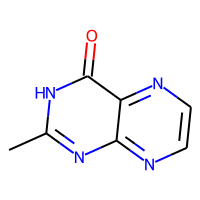
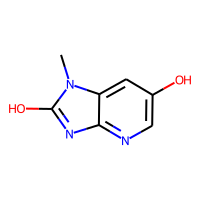
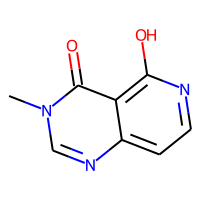
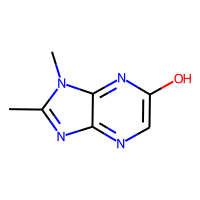
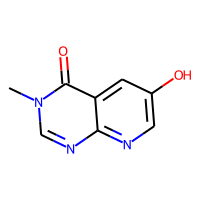
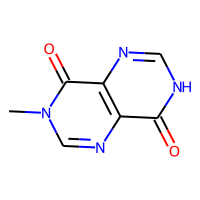
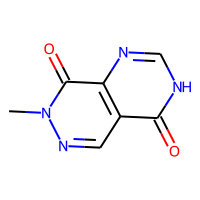
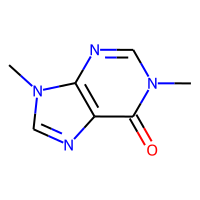
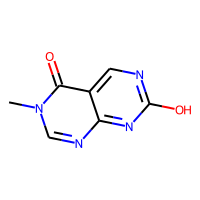

RUN IN TERMINAL in MassGenie folder: bash ./geneval_extended_support_script.sh
When the script is done computing, you can continue


Has the script finished? [y/n]:  y


OK..



<ipython-input-10-5d5ed10a8086>:62: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:983.)
  last_idx = inputs["attention_mask"].nonzero()[-1].item()+1


3.251373336211726


ic| gt_smiles: ' O=c1n(C)cnc2c1cnn2C'


,index,smiles,zinc_id,Molecule,mz,intensity,NEIMS_matched_peaks,NEIMS_simil,SMILES_simil
0,5,Cn1cnc2c(cnn2C)c1=O,,,"[28, 38, 39, 40, 41, 42, 43, 44, 51, 52, 53, 5...","[0.04, 0.06, 0.08, 0.11, 0.15, 0.31, 0.13, 0.0...",45,0.803821,1.000000
1,1,Cc1nc2[nH]ncc2c(=O)[nH]1,,,"[38, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 5...","[0.09, 0.01, 0.23, 0.18, 0.61, 0.14, 0.2, 0.03...",26,0.475772,0.530327
2,7,Cc1nc2[nH]ncc2c(=O)[nH]1,,,"[38, 39, 40, 41, 42, 43, 44, 50, 51, 52, 53, 5...","[0.09, 0.01, 0.23, 0.18, 0.61, 0.14, 0.2, 0.03...",26,0.475772,0.530327
3,3,Cn1cnc2ncn(C)c2c1=O,,,"[15, 17, 26, 27, 28, 29, 30, 37, 38, 39, 40, 4...","[0.02, 0.0, 0.03, 0.08, 0.09, 0.01, 0.02, 0.03...",45,0.861572,0.324818
4,4,Cc1cnc2c(n1)c(=O)[nH]n2C,,,"[26, 28, 29, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[0.01, 0.02, 0.01, 0.08, 0.17, 0.19, 0.28, 0.3...",41,0.818602,0.313641
5,6,Cc1cnc2c(n1)c(=O)[nH]n2C,,,"[26, 28, 29, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[0.01, 0.02, 0.01, 0.08, 0.17, 0.19, 0.28, 0.3...",41,0.818602,0.313641
6,8,Cc1nn(C)c2nc(O)cnc12,,,"[14, 15, 26, 27, 28, 29, 37, 38, 39, 40, 41, 4...","[0.01, 0.02, 0.04, 0.06, 0.07, 0.02, 0.09, 0.1...",36,0.822283,0.280124
7,0,Cc1cnc2c(=O)[nH]nc(O)c2n1,,,"[28, 37, 38, 39, 40, 41, 42, 43, 44, 49, 50, 5...","[0.01, 0.07, 0.16, 0.19, 0.2, 0.18, 0.42, 0.27...",35,0.547170,0.229990
8,2,Cc1nc2ncc(O)nc2n1C,,,"[37, 38, 39, 40, 41, 42, 43, 44, 49, 50, 51, 5...","[0.04, 0.12, 0.18, 0.2, 0.22, 0.42, 0.14, 0.06...",38,0.839728,0.209357

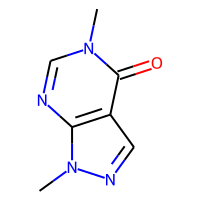
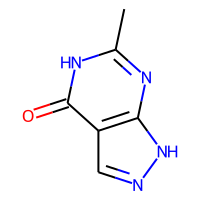
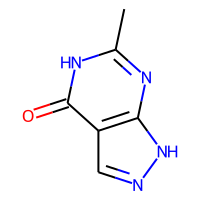
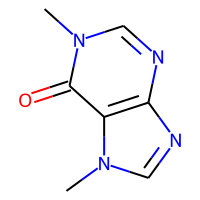
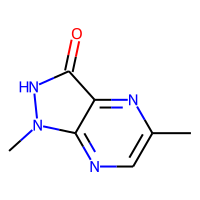
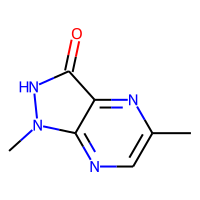
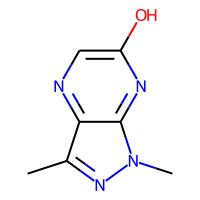
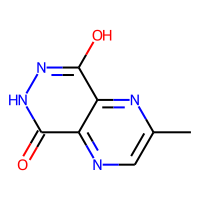
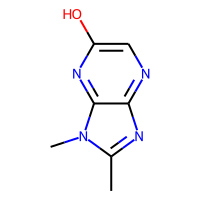

In [10]:
def evaluate_datapoint(inputs, num_generated=10, top_k=None, top_p=0.8, do_sample=True, num_beams=1, temperature=None, printing=True):
#     inputs = data[id_]
    if tokenizer_type:
        gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
    else:
        x = np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist())
        gt_smiles = tokenizer.ids_to_smiles(x[x>0][1:-1])
    generated_smiless = []
              
    # generate
    input_ids = inputs["input_ids"].unsqueeze(0).to(device=device)
    generated_outputs = model.generate(
                           input_ids=input_ids,
                           num_return_sequences = num_generated,
                           position_ids=inputs["position_ids"].unsqueeze(0).to(device=device),
                           top_p=top_p,
                           top_k=top_k,
        #                    min_length=20,
        #                    max_length=200,
                           do_sample=do_sample,
                           num_beams=num_beams,
                           temperature=temperature,
                           return_dict_in_generate=True,
                           output_scores=False)

    # decode the generated SMILESs
    generated_smiless = [tokenizer.decode(generated[1:-1]) for generated in generated_outputs.sequences.tolist()]

    # deduplicate (or not)
    unique_smiless = generated_smiless # unique_nonsorted(np.array(generated_smiless)) #####################################
    
    # filter invalid
    valid_smiless = [s for s in unique_smiless if Chem.MolFromSmiles(s)]
    
    # canonize
    canon_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in valid_smiless]
    
    df_valid_smiles = pd.DataFrame(canon_smiles, columns=["smiles"])
    
    PandasTools.AddMoleculeColumnToFrame(df_valid_smiles, smilesCol='smiles', molCol='ROMol')
    
    display(df_valid_smiles)
    # exporting to SDF
    PandasTools.WriteSDF(df_valid_smiles, "./tmp/tmp_for_NEIMS.sdf", properties=list(df_valid_smiles.columns))

    ################# NEIMS bash commands #####################    
    print("RUN IN TERMINAL in MassGenie folder: " + "bash ./geneval_extended_support_script.sh")
    print("When the script is done computing, you can continue")
    ans=""
    while ans!="y":
        ans = input("Has the script finished? [y/n]: ")
    print("OK..\n")
    ###########################################################
    
    # load sdf
    df = PandasTools.LoadSDF("./tmp/tmp_for_NEIMS_enriched.sdf", idName="zinc_id", molColName='Molecule')
    df = process_spec(df)
    
    # compute NEIMS simil
    cosine_greedy = CosineGreedy(tolerance=0.0) # tolerance je stejne naprd
    last_idx = inputs["attention_mask"].nonzero()[-1].item()+1
    orig_spec = Spectrum(mz=np.array(inputs["input_ids"][:last_idx], dtype=float), intensities=np.array((inputs["position_ids"][:last_idx]+1)/10, dtype=float))
    gen_specs = [Spectrum(mz=np.array(row[1]["mz"], dtype=np.float), intensities=np.array(row[1]["intensity"])) for row in df.iterrows()]
    cossim_out = cosine_greedy.matrix(references=[orig_spec], queries=gen_specs)
    neims_simils = [x[0] for x in cossim_out[0]]
    matched_peaks = [x[1] for x in cossim_out[0]]

    df["NEIMS_matched_peaks"] = matched_peaks
    df["NEIMS_simil"] = neims_simils
    
    # compute SMILES simil (just for reference)
    ms = [Chem.MolFromSmiles(smiles) for smiles in df["smiles"]]
    gt_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(gt_smiles)) 
    fps = [Chem.RDKFingerprint(x) for x in ms if x]
    smiles_simils = [DataStructs.FingerprintSimilarity(fp, gt_fp) for fp in fps]
    
    # here transform the list to ranking
    rmse = rmse_simils_unique(neims_simils, smiles_simils)[0]
    print(rmse)
    ic(gt_smiles)
    # compare the two simil lists (RMSE)
    
    df["SMILES_simil"] = smiles_simils
    
    return df.sort_values(by="SMILES_simil", ascending=False).reset_index()


evaluate_datapoint(test_data[14002]) #1005

# Evaluate range of datapoints (OPTION 1)
- OPTION1 with NEIMS back translation
- set data range and similarity metric and measure RMSE recall@1 and recall@2



What the script does
- Generate all the dfs and add them to one big DataFrame
- distinguish different datapoint lines with datapoint ID
- generate SMILES for all the molecules in the DataFrame
- do the RMSE and visualize the results


  0%|          | 0/1 [00:00<?, ?it/s]/storage/brno2/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/transformers/generation_utils.py:1202: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


Dataframe created
molecules ADDED TO THE DATAFRAME
sdf written to the file
RUN IN TERMINAL: bash ~/Spektro/MassGenie/geneval_extended_support_script.sh


Has the script finished? [y/n]:  y


OK..



,datapoint_ID,generated_smiless,gt_smiles,zinc_id,Molecule,mz,intensity,smiles_simils
3,12000,CCc1ccc(OCC2CC2)c(C=O)c1,O=Cc1cc(CC)ccc1OCC1CC1,,,"[26, 27, 28, 29, 38, 39, 40, 41, 42, 43, 44, 5...","[0.03, 0.29, 0.07, 0.27, 0.05, 0.55, 0.16, 0.3...",1.000000
5,12000,Cc1ccc(OCC2CCC2)c(C=O)c1,O=Cc1cc(CC)ccc1OCC1CC1,,,"[27, 28, 29, 38, 39, 40, 41, 42, 43, 44, 50, 5...","[0.13, 0.05, 0.09, 0.04, 0.54, 0.19, 0.36, 0.0...",0.813472
7,12000,Cc1ccc(OCC2CCC2)c(C=O)c1,O=Cc1cc(CC)ccc1OCC1CC1,,,"[27, 28, 29, 38, 39, 40, 41, 42, 43, 44, 50, 5...","[0.13, 0.05, 0.09, 0.04, 0.54, 0.19, 0.36, 0.0...",0.813472
8,12000,Cc1ccc(OCC2CCC2)c(C=O)c1,O=Cc1cc(CC)ccc1OCC1CC1,,,"[27, 28, 29, 38, 39, 40, 41, 42, 43, 44, 50, 5...","[0.13, 0.05, 0.09, 0.04, 0.54, 0.19, 0.36, 0.0...",0.813472
4,12000,CCc1cccc(C=O)c1OCC1CC1,O=Cc1cc(CC)ccc1OCC1CC1,,,"[26, 27, 28, 29, 31, 38, 39, 40, 41, 42, 43, 4...","[0.07, 0.36, 0.14, 0.47, 0.0, 0.05, 0.54, 0.13...",0.783848
0,12000,Cc1cccc(C=O)c1OCC1CCC1,O=Cc1cc(CC)ccc1OCC1CC1,,,"[27, 28, 29, 38, 39, 40, 41, 42, 50, 51, 52, 5...","[0.17, 0.02, 0.17, 0.06, 0.6, 0.11, 0.27, 0.07...",0.714640
6,12000,Cc1cccc(C=O)c1OCC1CCC1,O=Cc1cc(CC)ccc1OCC1CC1,,,"[27, 28, 29, 38, 39, 40, 41, 42, 50, 51, 52, 5...","[0.17, 0.02, 0.17, 0.06, 0.6, 0.11, 0.27, 0.07...",0.714640
2,12000,CCc1ccc(C=O)c(OCC2CC2)c1,O=Cc1cc(CC)ccc1OCC1CC1,,,"[25, 26, 27, 28, 29, 38, 39, 40, 41, 42, 50, 5...","[0.01, 0.06, 0.29, 0.1, 0.19, 0.03, 0.37, 0.07...",0.693735
9,12000,CCc1ccc(C=O)c(OCC2CC2)c1,O=Cc1cc(CC)ccc1OCC1CC1,,,"[25, 26, 27, 28, 29, 38, 39, 40, 41, 42, 50, 5...","[0.01, 0.06, 0.29, 0.1, 0.19, 0.03, 0.37, 0.07...",0.693735
1,12000,Cc1c(C=O)cccc1OCC1CCC1,O=Cc1cc(CC)ccc1OCC1CC1,,,"[26, 27, 28, 29, 37, 38, 39, 40, 41, 42, 44, 5...","[0.02, 0.19, 0.1, 0.22, 0.04, 0.17, 0.73, 0.25...",0.506250

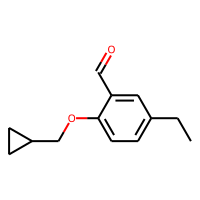
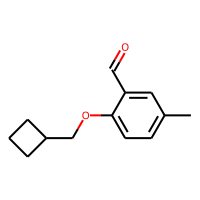
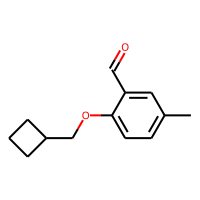
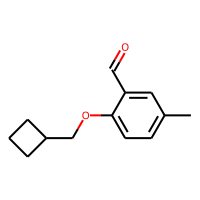
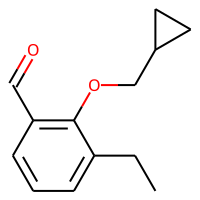
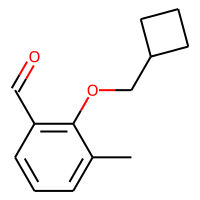
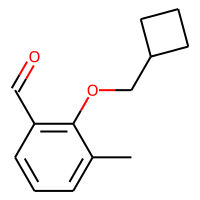
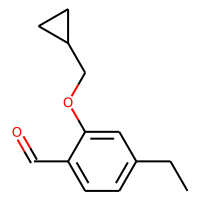
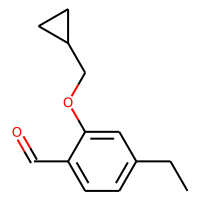
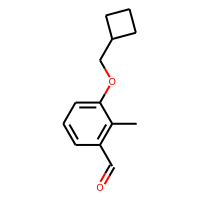

In [18]:
# %%time
# append: 10.6
# concat: 10.6
# lists: 10.6
def evaluate_range(data, data_range, simil_metric=CosineGreedy(tolerance=0.0), additional_info="", num_generated=10, top_k=None, top_p=0.8, do_sample=True, num_beams=1, temperature=None, printing=True):
    all_datapoint_ids = []
    all_smiles = []
    gt_smiless = []
    for id_ in tqdm(data_range):
        inputs = data[id_]
        if tokenizer_type:
            gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
        else:
            x = np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist())
            gt_smiles = tokenizer.ids_to_smiles(x[x>0][1:-1])
        generated_smiless = []
        
        # generate
        input_ids = inputs["input_ids"].unsqueeze(0).to(device=device)
        generated_outputs = model.generate(
                               input_ids=input_ids,
                               num_return_sequences = num_generated,
                               position_ids=inputs["position_ids"].unsqueeze(0).to(device=device),
                               top_p=top_p,
                               top_k=top_k,
            #                    min_length=20,
            #                    max_length=200,
                               do_sample=do_sample,
                               num_beams=num_beams,
                               temperature=temperature,
                               return_dict_in_generate=True,
                               output_scores=True)

        # decode the generated SMILESs
        generated_smiless = [tokenizer.decode(generated[1:-1]) for generated in generated_outputs.sequences.tolist()]
        
        # deduplicate (or not)
        unique_smiless = generated_smiless # np.unique(np.array(generated_smiless)) #####################################

        # filter invalid
        valid_smiless = [s for s in unique_smiless if Chem.MolFromSmiles(s)]
        
        # canonize
        canon_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in valid_smiless]
        
        all_smiles += canon_smiles
        all_datapoint_ids += [id_]*len(canon_smiles)
        gt_smiless += [gt_smiles]*len(canon_smiles)
        
    df_all_data = pd.DataFrame({"datapoint_ID":all_datapoint_ids, 
                                "generated_smiless": all_smiles, 
                                "gt_smiles": gt_smiless})
    
    print("Dataframe created")
    
    # adding a RDKit molecule representation of SMILES
    PandasTools.AddMoleculeColumnToFrame(df_all_data, smilesCol='generated_smiless', molCol='ROMol')
    
    print("molecules ADDED TO THE DATAFRAME")
    
    # exporting to SDF
    PandasTools.WriteSDF(df_all_data, "./tmp/tmp_for_NEIMS.sdf", properties=list(df_all_data.columns))
    print("sdf written to the file")
    

    ################# NEIMS bash commands #####################    
    print("RUN IN TERMINAL: " + "bash ~/Spektro/MassGenie/geneval_extended_support_script.sh")
    ans=""
    while ans!="y":
        ans = input("Has the script finished? [y/n]: ")
    print("OK..\n")
    ###########################################################
    
    # load sdf
    df_enriched = PandasTools.LoadSDF("./tmp/tmp_for_NEIMS_enriched.sdf", idName="zinc_id", molColName='Molecule')
    df_enriched = process_spec(df_enriched)
    df_enriched.datapoint_ID = df_enriched.datapoint_ID.astype(np.int32)
    
    rmses = []
    diff_unique_vals = 0 # check how many pairs of simil arrays have different num of unique vals
    success1 = 0
    success3 = 0
    unique_vals = 0
    for id_ in data_range:
        inputs = data[id_]
        df_id_subset = df_enriched[df_enriched['datapoint_ID'] == id_].copy()
        gt_smiles = df_id_subset["gt_smiles"].iloc[0]
        
        # compute NEIMS simil
        last_idx = inputs["attention_mask"].nonzero()[-1].item()+1
        orig_spec = Spectrum(mz=np.array(inputs["input_ids"][:last_idx], dtype=float), intensities=np.array((inputs["position_ids"][:last_idx]+1)/10, dtype=float))
        gen_specs = [Spectrum(mz=np.array(row[1]["mz"], dtype=np.float), intensities=np.array(row[1]["intensity"])) for row in df_id_subset.iterrows()]
        sim_out = simil_metric.matrix(references=[orig_spec], queries=gen_specs)
        neims_simils = [x[0] for x in sim_out[0]]
        
        # compute SMILES simil (just for reference)
        ms = [Chem.MolFromSmiles(smiles) for smiles in df_id_subset["generated_smiless"]]
        gt_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(gt_smiles)) 
        fps = [Chem.RDKFingerprint(x) for x in ms if x]
        smiles_simils = [DataStructs.FingerprintSimilarity(fp, gt_fp) for fp in fps]            
        
        
#         # showing dfs
#         df_id_subset["smiles_simils"] = smiles_simils
#         df_id_subset.sort_values(by="smiles_simils", ascending=False, inplace=True)
#         display(df_id_subset)
#         return
        
        # compare the two simil lists (RMSE)
        rmse, (idxs_NEIMS, idxs_GT) = rmse_simils_unique(neims_simils, smiles_simils)
        rmses.append(rmse)
        
        ### STATS        
        # check if different num of unique vals in this simil list pair
        if max(idxs_NEIMS) != max(idxs_GT):
            diff_unique_vals += 1
            df_id_subset["NEIMS_simil"] = neims_simils
            df_id_subset["NEIMS_idx"] = idxs_NEIMS
            df_id_subset["SMILES_idxs"] = idxs_GT
            df_id_subset["SMILES_simil"] = smiles_simils
            display(df_id_subset)
        if 0 == idxs_NEIMS[0]:
            success1 += 1 
        if 0 in idxs_NEIMS[:3]:
            success3 += 1
        unique_vals += max(idxs_NEIMS) + 1
        
    ############## OUTPUT ################
    model_name = ''.join(model_path.split('/')[-3])
    num_of_datapoints = max(data_range)-min(data_range)+1
    output_text = \
      f"model: {model_name}\n" + \
      f"similarity metric: {simil_metric.__class__.__name__}\n" + \
      f"additional info: {additional_info}\n" + \
      f"data range: ({min(data_range)}, {max(data_range)})\n"+ \
      f"generated for each example: {num_generated} samples\n"+\
      f"data type: {data_type}\n" +\
      f"mean RMSE of NEIMS_simil compared to GT: {sum(rmses)/len(rmses)}\n" +\
      f"ratio of different num of unique simil vals: {diff_unique_vals}/{num_of_datapoints}\n" +\
      f"recall@1: {success1/num_of_datapoints}\n"+\
      f"recall@3: {success3/num_of_datapoints}\n"+\
      f"mean num of unique vals: {unique_vals/num_of_datapoints}\n"
    print( f"###### RESULTS ######\n" + output_text)
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    histplot = sns.histplot(rmses, bins=100).set_title(output_text)
    fig = histplot.get_figure()
    
    fig.savefig(f"figures/option1_{simil_metric.__class__.__name__}{additional_info}_{model_name}_{data_type}_({min(data_range)}, {max(data_range)}).png", bbox_inches='tight') 
    return histplot


# similarity metrics: CosineGreedy, CosineHungarian
# simil_metric = CosineHungarian(mz_power=mz_power, intensity_power=intensity_power) #IntersectMz()
# mz_power = 1
# intensity_power = 1
# additional_info = f"_mzp{mz_power}_ip{intensity_power}_debugtry"

simil_metric = CosineGreedy()
additional_info="_unique"

evaluate_range(test_data, data_range=range(12000,12001), simil_metric=simil_metric, additional_info=additional_info)

# Evaluate datapoints OPTION 2 (probability)
- generate ?10? SMILES from input spektra
- sort them according to the generation probability
- get the recall@1 and recall@3 score

In [ ]:
# %%time
# import torch
# from transformers import AutoModelForCausalLM
# from transformers import AutoTokenizer

def evaluate_range(data, data_range, additional_info="", num_generated=100, top_k=None, top_p=0.8, do_sample=True, num_beams=1, temperature=None, printing=True):
    all_datapoint_ids = []
    all_smiles = []
    all_sequence_probs = []
    for id_ in tqdm(data_range):
        inputs = data[id_]
        if tokenizer_type:
            gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
        else:
            x = np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist())
            gt_smiles = tokenizer.ids_to_smiles(x[x>0][1:-1])
        generated_smiless = []

        # generate
        input_ids = inputs["input_ids"].unsqueeze(0).to(device=device)
        generated_outputs = model.generate(
                               input_ids=input_ids,
                               num_return_sequences = num_generated,
                               position_ids=inputs["position_ids"].unsqueeze(0).to(device=device),
                               top_p=top_p,
                               top_k=top_k,
            #                    min_length=20,
            #                    max_length=200,
                               do_sample=do_sample,
                               num_beams=num_beams,
                               temperature=temperature,
                               return_dict_in_generate=True,
                               output_scores=True)

        # decode the generated SMILESs
        generated_smiless = [tokenizer.decode(generated[1:-1]) for generated in generated_outputs.sequences.tolist()]
        generated_smiless_enum = list(enumerate(generated_smiless)) # enum for analizing which smiles drops after validation
        
        # filter invalid
        valid_smiless = [s for s in generated_smiless_enum if Chem.MolFromSmiles(s[1])]
        valid_idxs = [s[0] for s in valid_smiless]
        
        # canonize
        canon_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smi[1]),True) for smi in valid_smiless]
    
        ### PROBS computig
        # let's stack the logits generated at each step to a tensor and transform logits to probs
        raw_probs = torch.stack(generated_outputs.scores, dim=1).softmax(-1)  # -> shape [3, 15, vocab_size]

        # collect the probability of the generated token
        token_probs = torch.gather(raw_probs, 2, generated_outputs.sequences[:, 1:, None]).squeeze(-1)
        
        # filter out invalid smiles
        valid_token_probs = torch.index_select(token_probs, 0, torch.tensor(valid_idxs, dtype=torch.int64).to(device))

        # normalize the probs ?or not?
#         valid_token_probs = valid_token_probs / valid_token_probs.sum(0)
#         assert valid_token_probs[:, 0].sum() == 1.0, "probs should be normalized"
        
        # multiply all the probs in each sequence except for the zero values
        valid_token_probs[valid_token_probs==0] = 1 # replace zeros for neutral element -> 1

        sequence_probs = valid_token_probs.prod(dim=1).tolist()
        
        ic(token_probs, sequence_probs) if torch.isnan(torch.tensor(sequence_probs)).any() else None ###########################################################
    
        all_smiles += canon_smiles
        all_datapoint_ids += [id_]*len(canon_smiles)
        all_sequence_probs += sequence_probs
    
    ic(len(all_datapoint_ids), len(all_sequence_probs), len(all_smiles))
    
    
    df_all_data = pd.DataFrame({"datapoint_ID":all_datapoint_ids, 
                                "smiles": all_smiles,
                                "smiles_prob": all_sequence_probs})   
    
    rmses = []
    diff_unique_vals = 0 # check how many pairs of simil arrays have different num of unique vals
    success1 = 0
    success3 = 0
    unique_vals = 0
    for id_ in data_range:
        inputs = data[id_]
        gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
        df_id_subset = df_all_data[df_all_data['datapoint_ID'] == id_].copy()
        
        # compute SMILES simil (just for reference)
        ms = [Chem.MolFromSmiles(smiles) for smiles in df_id_subset["smiles"]]
        gt_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(gt_smiles)) 
        fps = [Chem.RDKFingerprint(x) for x in ms if x]
        smiles_simils = [DataStructs.FingerprintSimilarity(fp, gt_fp) for fp in fps]            
        
        # get computed probs from df
        smiles_probs = df_id_subset["smiles_prob"]

#         # showing dfs
#         df_id_subset["smiles_simils"] = smiles_simils
#         df_id_subset.sort_values(by="smiles_simils", ascending=False, inplace=True)
#         display(df_id_subset)
#         return
        
        # compare the two simil lists (RMSE)
        rmse, (idxs_prob, idxs_GT) = rmse_simils_unique(smiles_probs, smiles_simils)
        rmses.append(rmse)

        ### STATS        
        if 0 == idxs_prob[0]:
            success1 += 1 
        if 0 in idxs_prob[:3]:
            success3 += 1
        unique_vals += max(idxs_prob) + 1
            
    ############## OUTPUT ################
    model_name = ''.join(model_path.split('/')[-3])
    num_of_datapoints = max(data_range)-min(data_range)+1
    output_text = \
      f"model: {model_name}\n" + \
      f"additional info: {additional_info}\n" + \
      f"data range: ({min(data_range)}, {max(data_range)})\n"+ \
      f"generated for each example: {num_generated} samples\n"+\
      f"data type: {data_type}\n" +\
      f"mean RMSE of NEIMS_simil compared to GT: {sum(rmses)/len(rmses)}\n" +\
      f"recall@1: {success1/num_of_datapoints}\n"+\
      f"recall@3: {success3/num_of_datapoints}\n"+\
      f"mean num of unique vals: {unique_vals/num_of_datapoints}\n"
    print(f"###### RESULTS ######\n" + output_text)
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    histplot = sns.histplot(rmses, bins=100).set_title(output_text)
    fig = histplot.get_figure()
    
    fig.savefig(f"figures/option2_prob{additional_info}_{model_name}_{data_type}_({min(data_range)}, {max(data_range)}).png", bbox_inches='tight') 
    return histplot

additional_info = ""
evaluate_range(test_data, num_generated=10, data_range=range(10000,15000), additional_info=additional_info)

# Evaluate datapoints OPTION 2 (dumb)
- generate ?100? SMILES from input spektra
- sort them according to number of SMILES of each kind
- get the recall@1 score and recall@3 scoretoken_probs

  1%|          | 2/200 [00:00<00:52,  3.76it/s][18:01:30] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 7 9 10
[18:01:30] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8 9 10 11
[18:01:30] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 7 8
[18:01:30] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 7 8
[18:01:30] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 9 10
[18:01:30] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8 9 10 11
[18:01:30] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 9 10
  2%|▎         | 5/200 [00:01<00:55,  3.50it/s][18:01:31] SMILES Parse Error: ring closure 1 duplicates bond between atom 10 and atom 11 for input: ' Brc1ccnc(c1C1CC1)C1N1'
[18:01:31] SMILES Parse Error: ring closure 1 duplicates bond between atom 10 and atom 11 for input: ' Brc1cnc(c(c1)C1CC1)C1N1'
 10%|▉         | 19/200 [00:05<00:44,  4.10it/s][18:01:35] Can't kekulize mol.  Unkekulized atoms: 13 16 17
[18:01:35] Can't kekulize mol.  Unkekulized atoms: 13 16 17
[18:01:35] Can

###### RESULTS ######
model: bart_2022-06-28-10_02_31_bigdata
additional info: 
data range: (14000, 14199)
generated for each example: 100 samples
data type: 8M
mean RMSE of NEIMS_simil compared to GT: 6.392474476520598
recall@1: 0.195
recall@3: 0.415
mean num of unique vals: 17.58



Text(0.5, 1.0, 'model: bart_2022-06-28-10_02_31_bigdata\nadditional info: \ndata range: (14000, 14199)\ngenerated for each example: 100 samples\ndata type: 8M\nmean RMSE of NEIMS_simil compared to GT: 6.392474476520598\nrecall@1: 0.195\nrecall@3: 0.415\nmean num of unique vals: 17.58\n')

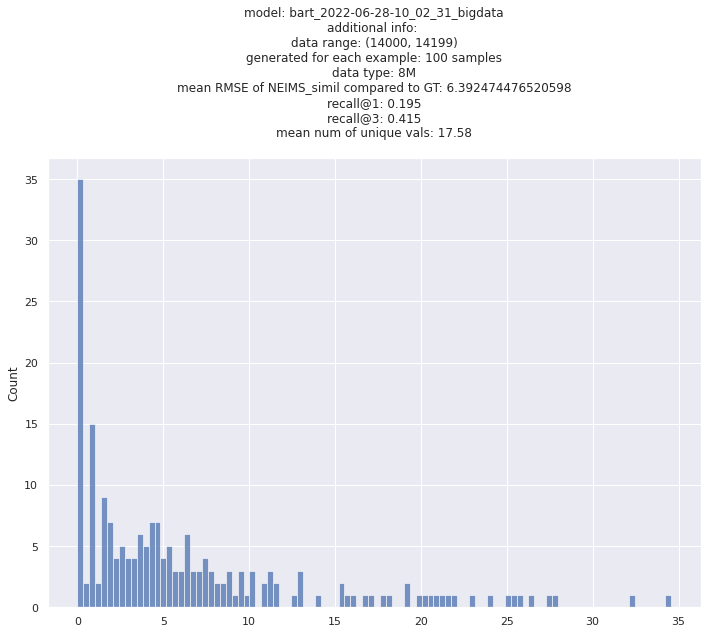

In [12]:
# %%time
# append: 10.6
# concat: 10.6
# lists: 10.6
def evaluate_range(data, data_range, additional_info="", num_generated=100, top_k=None, top_p=0.8, do_sample=True, num_beams=1, temperature=None, printing=True):
    all_datapoint_ids = []
    all_smiles = []
    for id_ in tqdm(data_range):
        inputs = data[id_]
        if tokenizer_type:
            gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
        else:
            x = np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist())
            gt_smiles = tokenizer.ids_to_smiles(x[x>0][1:-1])
        generated_smiless = []

        # generate
        input_ids = inputs["input_ids"].unsqueeze(0).to(device=device)
        generated_outputs = model.generate(
                               input_ids=input_ids,
                               num_return_sequences = num_generated,
                               position_ids=inputs["position_ids"].unsqueeze(0).to(device=device),
                               top_p=top_p,
                               top_k=top_k,
            #                    min_length=20,
            #                    max_length=200,
                               do_sample=do_sample,
                               num_beams=num_beams,
                               temperature=temperature,
                               return_dict_in_generate=True,
                               output_scores=True)

        # decode the generated SMILESs
        generated_smiless = [tokenizer.decode(generated[1:-1]) for generated in generated_outputs.sequences.tolist()]
        
        # deduplicate (or not)
        unique_smiless = generated_smiless # np.unique(np.array(generated_smiless)) #####################################

        # filter invalid
        valid_smiless = [s for s in unique_smiless if Chem.MolFromSmiles(s)]

        # canonize
        canon_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in valid_smiless]
        
        all_smiles += canon_smiles
        all_datapoint_ids += [id_]*len(canon_smiles)
    
    df_all_data = pd.DataFrame({"datapoint_ID":all_datapoint_ids, "smiles": all_smiles})
    
    success1 = 0
    success3 = 0
    unique_vals = 0
    rmses = []
    for id_ in data_range:
        inputs = data[id_]
        gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
        df_id_subset = df_all_data[df_all_data['datapoint_ID'] == id_].copy()
        
        # compute SMILES simil (just for reference)
        ms = [Chem.MolFromSmiles(smiles) for smiles in df_id_subset["smiles"]]
        gt_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(gt_smiles)) 
        fps = [Chem.RDKFingerprint(x) for x in ms if x]
        smiles_simils = [DataStructs.FingerprintSimilarity(fp, gt_fp) for fp in fps]            
        
        df_id_subset["smiles_simils"] = smiles_simils
        countwise_sorted_SMILES = list(df_id_subset["smiles"].value_counts().keys())
        
        # compute values for countwise metric (the higher the better -> substracting from len(...))
        num_unique = len(countwise_sorted_SMILES)
        count_simil = [num_unique - countwise_sorted_SMILES.index(s) for s in df_id_subset["smiles"]]
        
        df_id_subset["countwise_idxs"] = count_simil  
               
         # compare the two simil lists (RMSE)
        rmse, (idxs_count, idxs_GT) = rmse_simils_unique(count_simil, smiles_simils)
        rmses.append(rmse)

        df_id_subset.sort_values(by="smiles_simils", inplace=True)
        gen_SMILES = df_id_subset.smiles.unique()
        best_gen_SMILES = gen_SMILES[0]
        
#                 showing dfs
#         ic(rmse, (idxs_count, idxs_GT))
#         ic(best_gen_SMILES)
#         gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
#         ic(gt_smiles)
#         display(df_id_subset)
#         return
        
        
        
        ### STATS        
        # check if different num of unique vals in this simil list pair
        if best_gen_SMILES == countwise_sorted_SMILES[0]:
            success1 += 1 
        if best_gen_SMILES in countwise_sorted_SMILES[:3]:
            success3 += 1
        unique_vals += len(gen_SMILES)
            
    ############## OUTPUT ################
    model_name = ''.join(model_path.split('/')[-3])
    num_of_datapoints = max(data_range)-min(data_range)+1
    output_text = \
      f"model: {model_name}\n" + \
      f"additional info: {additional_info}\n" + \
      f"data range: ({min(data_range)}, {max(data_range)})\n"+ \
      f"generated for each example: {num_generated} samples\n"+\
      f"data type: {data_type}\n" +\
      f"mean RMSE of NEIMS_simil compared to GT: {sum(rmses)/len(rmses)}\n" +\
      f"recall@1: {success1/num_of_datapoints}\n"+\
      f"recall@3: {success3/num_of_datapoints}\n"+\
      f"mean num of unique vals: {unique_vals/num_of_datapoints}\n"
    print( f"###### RESULTS ######\n" + output_text)
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    histplot = sns.histplot(rmses, bins=100).set_title(output_text)
    fig = histplot.get_figure()
    
    fig.savefig(f"figures/option2_dumb{additional_info}_{model_name}_{data_type}_({min(data_range)}, {max(data_range)}).png", bbox_inches='tight') 
    return histplot


evaluate_range(test_data, num_generated=100, data_range=range(14000,14200), additional_info="")